## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Вахрушев Вадим Юрьевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from train_utils import train
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [5]:
images_train, labels_train = next(iter(train_loader))

In [26]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

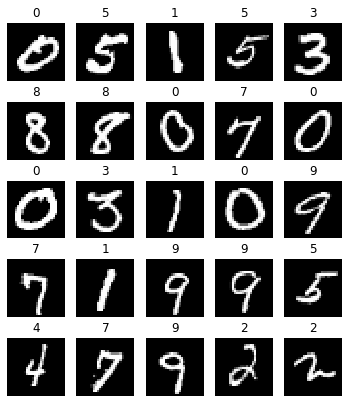

In [27]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [28]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [29]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [41]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def he_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0])
    weight.normal_(mean=0, std=np.sqrt(d))
    
init_f = xavier_init_uni
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9786947965621948
forward 1.0815764665603638
forward 0.6400218605995178
forward 0.4922075867652893
forward 0.41076046228408813
forward 0.3554683029651642
forward 0.32113412022590637
forward 0.2914227247238159
forward 0.2691468894481659
forward 0.2567002773284912
backward 0.02828427404165268
backward 0.019194170832633972
backward 0.017399035394191742
backward 0.015727251768112183
backward 0.01391131617128849
backward 0.012134094722568989
backward 0.010242730379104614
backward 0.00828502420336008
backward 0.0051550124771893024
backward 0.005484428256750107


In [42]:
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9786947965621948
forward 1.0906611680984497
forward 0.6275292038917542
forward 0.44518399238586426
forward 0.32431381940841675
forward 0.2249089479446411
forward 0.16933467984199524
forward 0.11454328149557114
forward 0.08445567637681961
forward 0.05579833313822746
backward 0.02828427404165268
backward 0.012878487817943096
backward 0.008303101174533367
backward 0.005041252356022596
backward 0.003446698421612382
backward 0.002152904635295272
backward 0.00144104880746454
backward 0.0008919035317376256
backward 0.0005669691017828882
backward 0.0005931578925810754


Градиент затухает на порядок сильнее

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [43]:

init_f = he_init
    
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9786947965621948
forward 1.721390962600708
forward 1.4192925691604614
forward 1.4378235340118408
forward 1.4354965686798096
forward 1.450679063796997
forward 1.356363296508789
forward 1.3310397863388062
forward 1.2870248556137085
forward 1.2604577541351318
backward 0.02828427404165268
backward 0.09380843490362167
backward 0.08589661866426468
backward 0.07449407130479813
backward 0.0684535950422287
backward 0.05882871896028519
backward 0.05183660611510277
backward 0.04813772439956665
backward 0.041510120034217834
backward 0.05857326090335846


In [44]:
net = []
net.append(make_linear(28*28, 500, init_f))
for i in range(8):
    net.append(make_linear(500, 500, init_f))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_f))
net = nn.Sequential(*net)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 0.9786947965621948
forward 1.7455717325210571
forward 0.8304435014724731
forward 0.6731553673744202
forward 0.6176924705505371
forward 0.5847198963165283
forward 0.5721656084060669
forward 0.5662685036659241
forward 0.5585695505142212
forward 0.5524746179580688
backward 0.02828427404165268
backward 0.10289791226387024
backward 0.09947341680526733
backward 0.10035449266433716
backward 0.09649558365345001
backward 0.089802086353302
backward 0.08360596001148224
backward 0.06846476346254349
backward 0.036848146468400955
backward 0.05040056258440018


backward одинаковый, однако при прямом проходе значения при Tanh меньше.

<i> 1.4 Сделайте выводы по первой части </i>

Итак, для ReLU лучше использовать He, для Tanh - Glorot

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [45]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()        
        self.lin = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.ones_like(self.lin.weight) * self.p
        
        if self.training:
            mask = torch.ones_like(self.lin.weight) * self.p
            mask.bernoulli_()
            
        mask.detach_()

        output = torch.mm(x, (self.lin.weight*mask).transpose(0, 1))+self.lin.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [67]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(nn.Linear(in_dim, out_dim))
    net.append(nn.Dropout(0.5))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.616/0.335	Accuracy: 0.841/0.922


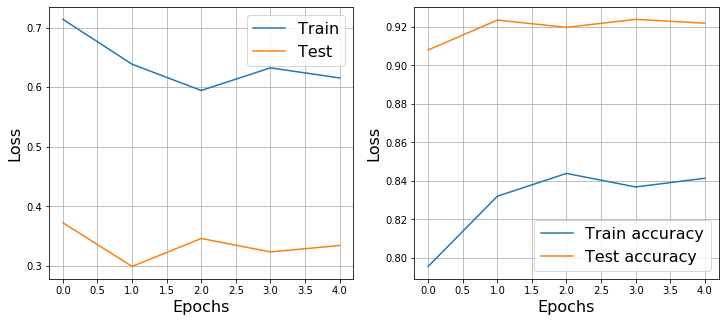

([0.7137938921512571,
  0.6385637697126312,
  0.5945503859758885,
  0.6324900574267291,
  0.6155404442154777],
 [0.3727611769226533,
  0.2994822546651092,
  0.3463944690891459,
  0.32385479451357563,
  0.33460470543632026],
 [0.79549795, 0.8319951, 0.8438611, 0.83682036, 0.8413457],
 [0.9080301, 0.92355615, 0.91979825, 0.92395175, 0.9219739])

In [68]:
t1 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')
t1

In [69]:
net = [Flatten()]

sizes = [28**2, 200, 200]
for in_dim, out_dim in zip(sizes, sizes[1:]):    
    net.append(DropConnect(in_dim, out_dim))
    net.append(nn.ReLU())
    
net.append(nn.Linear(sizes[-1], 10))
net.append(nn.LogSoftmax(1))
net = nn.Sequential(*net)

Epoch 4... (Train/Test) NLL: 0.258/0.165	Accuracy: 0.932/0.952


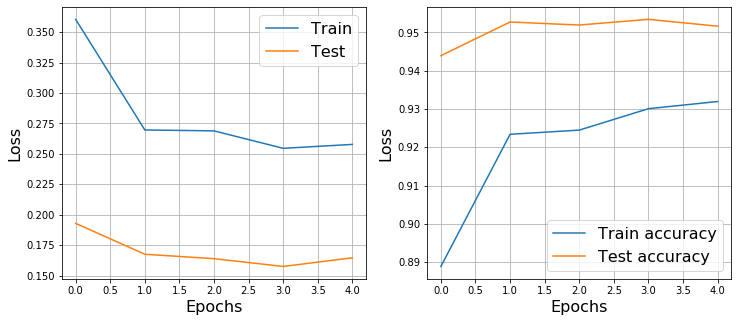

([0.3604976757407697,
  0.26961415653416854,
  0.2688675335348288,
  0.25452836975455284,
  0.2577366630342215],
 [0.1928570353532139,
  0.16747952133558597,
  0.16383943513413018,
  0.1574579945093469,
  0.1645427458459818],
 [0.8888481, 0.9233853, 0.92447364, 0.93007064, 0.9319474],
 [0.943928, 0.9527294, 0.9519383, 0.95342165, 0.9516416])

In [70]:
t2 = train(net, train_loader, test_loader, 5, 0.01, device='cpu')
t2

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

Как видно из графиков, DropConnect оказался лучше, чем DropOut

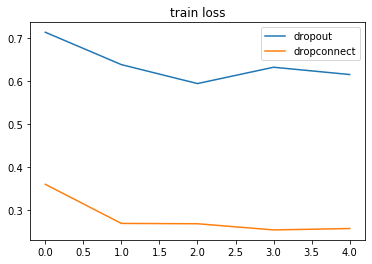

In [72]:
plt.plot(t1[0], label='dropout')
plt.plot(t2[0],  label='dropconnect')
plt.title('train loss')
plt.legend()
plt.show()

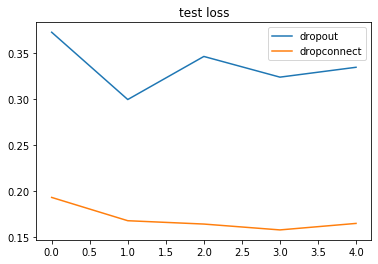

In [73]:
plt.plot(t1[1], label='dropout')
plt.plot(t2[1],  label='dropconnect')
plt.title('test loss')
plt.legend()
plt.show()

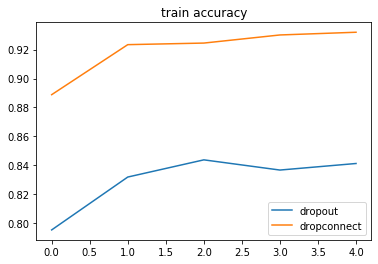

In [74]:
plt.plot(t1[2], label='dropout')
plt.plot(t2[2],  label='dropconnect')
plt.title('train accuracy')
plt.legend()
plt.show()

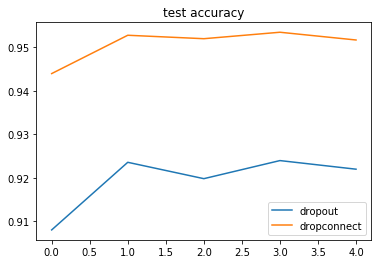

In [75]:
plt.plot(t1[3], label='dropout')
plt.plot(t2[3],  label='dropconnect')
plt.title('test accuracy')
plt.legend()
plt.show()

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [8]:
# полезные функции: .std(dim), .mean(dim)


class LayerNormalization(nn.Module):

    def __init__(self, features, eps=1e-5):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.041/0.077	Accuracy: 0.986/0.979


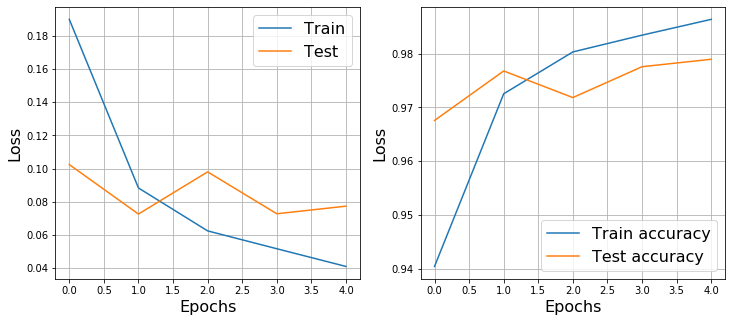

([0.1899498536237585,
  0.08831792309739267,
  0.06245136187910271,
  0.05169559675735483,
  0.04102089280919877],
 [0.1024244710142854,
  0.07260807351167962,
  0.09802427957471035,
  0.0727744578159874,
  0.0773493055238748],
 [0.9404318, 0.9725202, 0.98029935, 0.98341435, 0.9863517],
 [0.9675633, 0.97676027, 0.97181565, 0.9775514, 0.9789359])

In [9]:
#BatchNorm
network = nn.Sequential(nn.Linear(784, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        nn.BatchNorm1d(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01, ravel_init=True)

Epoch 4... (Train/Test) NLL: 0.048/0.095	Accuracy: 0.984/0.971


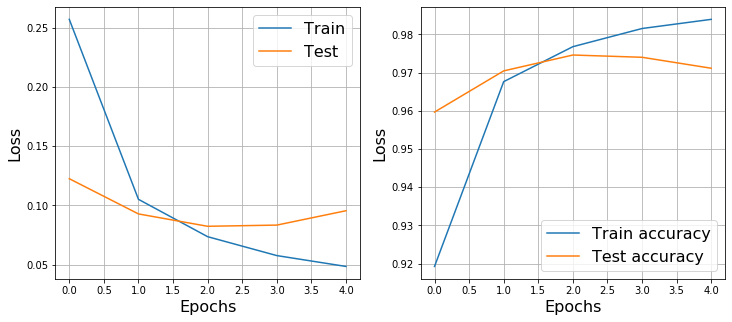

([0.2570829046592275,
  0.10508847046794413,
  0.07353688673829155,
  0.05757344463693181,
  0.048401750769140495],
 [0.12250040924247307,
  0.09276520851056409,
  0.0823143830617206,
  0.08332060223233097,
  0.09545242855961941],
 [0.9192431, 0.9676173, 0.9767679, 0.981521, 0.9839197],
 [0.9596519, 0.97043115, 0.97458464, 0.9739913, 0.9711234])

In [11]:
#LayerNorm
network = nn.Sequential(nn.Linear(784, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 200),
                        LayerNormalization(200),
                        nn.ReLU(),
                        nn.Linear(200, 10),
                        nn.LogSoftmax())

train(network, train_loader, test_loader, 5, 0.01, ravel_init=True)

<i> 3.3 Сделайте выводы по третьей части </i>

Как видно из графиков, BatchNormalization показывает себя чуть лучше, чем LayerNormalization, однако разница между ними незначительна.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: